In [1]:
import tensorflow as tf
tf.executing_eagerly()
print(tf.executing_eagerly())

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import functools

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

from tensorflow import keras
from tensorflow.keras import datasets, Input, layers, models, Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import backend as B
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from functools import partial

physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)


True


In [2]:
data = pd.read_csv('POD_coeff_M13_new.csv')
data_save=data.values
print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save


(201, 92)
92


In [3]:
mode = 2
num_param = 7
latent_dim = 2
batch_size = num_param
num_snapshot = 200


print('mode = %d' % mode)

mode = 2


In [4]:
train_ratio=1
val_ratio=0
   
param_data=[]
param_data.append(data[0,mode*num_param-(num_param-1):mode*num_param+1])
param_data=np.asarray(param_data)
print(param_data)

y_train=[]

y_train.append(data[1:num_snapshot+1,mode*num_param-(num_param-1):mode*num_param+1])
y_train=np.asarray(y_train)
y_train=np.reshape(y_train,(y_train.shape[1],y_train.shape[2]))
y_train=np.transpose(y_train)

x_train=y_train

maximum = np.amax(x_train)
x_train = x_train/maximum

x_train=np.reshape(x_train,[x_train.shape[0],x_train.shape[1],1])
print(x_train.shape)

DATA_shape=x_train.shape[1:]
print(DATA_shape)

timelength=y_train.shape[1]
print(timelength)

[[2.1 2.2 2.3 2.4 2.5 2.6 2.7]]
(7, 200, 1)
(200, 1)
200


In [5]:
x_axis = np.linspace(1,timelength,timelength)
x_axis.shape

(200,)

In [6]:
epoch=20000

filename1='LVAE_test_shared/mode%d/model_save_mode%d/encoder_%ds_%d.h5' % (mode, mode, timelength/100, epoch)
filename2='LVAE_test_shared/mode%d/model_save_mode%d/decoder_%ds_%d.h5' % (mode, mode, timelength/100, epoch)
       
print('epoch : ',epoch)

epoch :  20000


In [8]:
Encoder = load_model(filename1)
Encoder.summary()
# tf.keras.utils.plot_model(Encoder, show_shapes=True)

Decoder = load_model(filename2)
Decoder.summary()
# tf.keras.utils.plot_model(Decoder, show_shapes=True)

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 1)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 1)       4           input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 200, 1)       0           batch_normalization[0][0]        
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 200)       0           input_1[0][0]                    
____________________________________________________________________________________________

Model: "DECODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 2, 1)         0           input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 2, 1)         4           reshape_5[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 2, 1)         0           batch_normalization_5[0][0]      
____________________________________________________________________________________________

# Find latent vector

In [10]:
n_epochs = 1000

def reparam(mu,var):
    
    eps = tf.random.normal(shape=[latent_dim], mean=0.0, stddev=1.0)
    z = eps * tf.math.sqrt(var) + mu
    
    return z

def find_latent(x_train):
    mu, var = Encoder(x_train, training=False)
    latent_vector = reparam(mu[-1], var[-1])
    gen_x, _,_,_ = Decoder(latent_vector, training=False)
    return latent_vector, gen_x

latent_vectors = np.zeros([batch_size, latent_dim])

start = time.time()
for j in range(num_param):
    start_param=time.time()
    latent_vector = np.zeros([1, latent_dim])
    loss_save = 1e+2
    x = x_train[j,:,:]
    x = np.reshape(x,(1,x.shape[0],x.shape[1]))
    for i in range(n_epochs):
        start_time = time.time()    
        latent_vector, gen_x = find_latent(x)
        loss = tf.math.reduce_mean(tf.math.square(x - gen_x))
        if loss < loss_save:
            loss_save = loss
            latent_vector_save = latent_vector
        del latent_vector    
        end_time = time.time()
        print('Epoch: {}''/{}'' - {:3f}s/step '' loss: {:1e}'.format(i+1,n_epochs, end_time - start_time, loss_save))
    
    latent_vectors[j,:] = latent_vector_save
    del latent_vector_save
    
    end_param=time.time()
    
    print('parameter {} is finished'' - {:3f}s'' loss: {:1e}'.format(j+1, end_param-start_param, loss_save))
    print(' ')
end = time.time()
print(' ')
print(end-start)


Epoch: 1/1000 - 2.000450s/step  loss: 1.758555e-02
Epoch: 2/1000 - 0.026006s/step  loss: 1.668465e-02
Epoch: 3/1000 - 0.022004s/step  loss: 1.668465e-02
Epoch: 4/1000 - 0.025006s/step  loss: 1.604867e-02
Epoch: 5/1000 - 0.025006s/step  loss: 1.604867e-02
Epoch: 6/1000 - 0.025007s/step  loss: 1.604867e-02
Epoch: 7/1000 - 0.024005s/step  loss: 1.604867e-02
Epoch: 8/1000 - 0.025005s/step  loss: 1.604867e-02
Epoch: 9/1000 - 0.024006s/step  loss: 1.577331e-02
Epoch: 10/1000 - 0.061022s/step  loss: 1.576653e-02
Epoch: 11/1000 - 0.042007s/step  loss: 1.576653e-02
Epoch: 12/1000 - 0.027006s/step  loss: 1.571196e-02
Epoch: 13/1000 - 0.027006s/step  loss: 1.571196e-02
Epoch: 14/1000 - 0.027006s/step  loss: 1.571196e-02
Epoch: 15/1000 - 0.027006s/step  loss: 1.571196e-02
Epoch: 16/1000 - 0.026006s/step  loss: 1.571196e-02
Epoch: 17/1000 - 0.027006s/step  loss: 1.571196e-02
Epoch: 18/1000 - 0.028006s/step  loss: 1.571196e-02
Epoch: 19/1000 - 0.029007s/step  loss: 1.571196e-02
Epoch: 20/1000 - 0.03

Epoch: 316/1000 - 0.021004s/step  loss: 1.500298e-02
Epoch: 317/1000 - 0.024006s/step  loss: 1.500298e-02
Epoch: 318/1000 - 0.054012s/step  loss: 1.500298e-02
Epoch: 319/1000 - 0.038008s/step  loss: 1.500298e-02
Epoch: 320/1000 - 0.026006s/step  loss: 1.500298e-02
Epoch: 321/1000 - 0.026006s/step  loss: 1.500298e-02
Epoch: 322/1000 - 0.025005s/step  loss: 1.500298e-02
Epoch: 323/1000 - 0.025006s/step  loss: 1.500298e-02
Epoch: 324/1000 - 0.025006s/step  loss: 1.500298e-02
Epoch: 325/1000 - 0.025006s/step  loss: 1.500298e-02
Epoch: 326/1000 - 0.027007s/step  loss: 1.500298e-02
Epoch: 327/1000 - 0.025007s/step  loss: 1.500298e-02
Epoch: 328/1000 - 0.029007s/step  loss: 1.500298e-02
Epoch: 329/1000 - 0.034006s/step  loss: 1.500298e-02
Epoch: 330/1000 - 0.026005s/step  loss: 1.500298e-02
Epoch: 331/1000 - 0.025006s/step  loss: 1.500298e-02
Epoch: 332/1000 - 0.024005s/step  loss: 1.500298e-02
Epoch: 333/1000 - 0.025006s/step  loss: 1.500298e-02
Epoch: 334/1000 - 0.026006s/step  loss: 1.5002

Epoch: 474/1000 - 0.024005s/step  loss: 1.500298e-02
Epoch: 475/1000 - 0.024005s/step  loss: 1.500298e-02
Epoch: 476/1000 - 0.024005s/step  loss: 1.500298e-02
Epoch: 477/1000 - 0.026006s/step  loss: 1.500298e-02
Epoch: 478/1000 - 0.023006s/step  loss: 1.500298e-02
Epoch: 479/1000 - 0.022005s/step  loss: 1.500298e-02
Epoch: 480/1000 - 0.040011s/step  loss: 1.500298e-02
Epoch: 481/1000 - 0.038007s/step  loss: 1.500298e-02
Epoch: 482/1000 - 0.029004s/step  loss: 1.500298e-02
Epoch: 483/1000 - 0.026006s/step  loss: 1.500298e-02
Epoch: 484/1000 - 0.025006s/step  loss: 1.500298e-02
Epoch: 485/1000 - 0.027006s/step  loss: 1.500298e-02
Epoch: 486/1000 - 0.024006s/step  loss: 1.500298e-02
Epoch: 487/1000 - 0.025005s/step  loss: 1.500298e-02
Epoch: 488/1000 - 0.025005s/step  loss: 1.500298e-02
Epoch: 489/1000 - 0.024006s/step  loss: 1.500298e-02
Epoch: 490/1000 - 0.026006s/step  loss: 1.500298e-02
Epoch: 491/1000 - 0.025006s/step  loss: 1.500298e-02
Epoch: 492/1000 - 0.026006s/step  loss: 1.5002

Epoch: 633/1000 - 0.040012s/step  loss: 1.500298e-02
Epoch: 634/1000 - 0.026006s/step  loss: 1.500298e-02
Epoch: 635/1000 - 0.026006s/step  loss: 1.500298e-02
Epoch: 636/1000 - 0.026006s/step  loss: 1.500298e-02
Epoch: 637/1000 - 0.025006s/step  loss: 1.500298e-02
Epoch: 638/1000 - 0.024005s/step  loss: 1.500298e-02
Epoch: 639/1000 - 0.024005s/step  loss: 1.500298e-02
Epoch: 640/1000 - 0.025006s/step  loss: 1.500298e-02
Epoch: 641/1000 - 0.026006s/step  loss: 1.500298e-02
Epoch: 642/1000 - 0.025004s/step  loss: 1.500298e-02
Epoch: 643/1000 - 0.030007s/step  loss: 1.500298e-02
Epoch: 644/1000 - 0.034008s/step  loss: 1.500298e-02
Epoch: 645/1000 - 0.026006s/step  loss: 1.500298e-02
Epoch: 646/1000 - 0.023006s/step  loss: 1.500298e-02
Epoch: 647/1000 - 0.024005s/step  loss: 1.500298e-02
Epoch: 648/1000 - 0.023005s/step  loss: 1.500298e-02
Epoch: 649/1000 - 0.025006s/step  loss: 1.500298e-02
Epoch: 650/1000 - 0.025006s/step  loss: 1.500298e-02
Epoch: 651/1000 - 0.024005s/step  loss: 1.5002

Epoch: 794/1000 - 0.022005s/step  loss: 1.500298e-02
Epoch: 795/1000 - 0.047010s/step  loss: 1.500298e-02
Epoch: 796/1000 - 0.041010s/step  loss: 1.500298e-02
Epoch: 797/1000 - 0.025006s/step  loss: 1.500298e-02
Epoch: 798/1000 - 0.029006s/step  loss: 1.500298e-02
Epoch: 799/1000 - 0.030007s/step  loss: 1.500298e-02
Epoch: 800/1000 - 0.028006s/step  loss: 1.500298e-02
Epoch: 801/1000 - 0.028006s/step  loss: 1.500298e-02
Epoch: 802/1000 - 0.028007s/step  loss: 1.500298e-02
Epoch: 803/1000 - 0.026006s/step  loss: 1.500298e-02
Epoch: 804/1000 - 0.027006s/step  loss: 1.500298e-02
Epoch: 805/1000 - 0.029007s/step  loss: 1.500298e-02
Epoch: 806/1000 - 0.034007s/step  loss: 1.500298e-02
Epoch: 807/1000 - 0.033008s/step  loss: 1.500298e-02
Epoch: 808/1000 - 0.028007s/step  loss: 1.500298e-02
Epoch: 809/1000 - 0.024005s/step  loss: 1.500298e-02
Epoch: 810/1000 - 0.025006s/step  loss: 1.500298e-02
Epoch: 811/1000 - 0.024005s/step  loss: 1.500298e-02
Epoch: 812/1000 - 0.025005s/step  loss: 1.5002

Epoch: 949/1000 - 0.025006s/step  loss: 1.492637e-02
Epoch: 950/1000 - 0.026006s/step  loss: 1.492637e-02
Epoch: 951/1000 - 0.026006s/step  loss: 1.492637e-02
Epoch: 952/1000 - 0.027006s/step  loss: 1.492637e-02
Epoch: 953/1000 - 0.026006s/step  loss: 1.492637e-02
Epoch: 954/1000 - 0.027006s/step  loss: 1.492637e-02
Epoch: 955/1000 - 0.034008s/step  loss: 1.492637e-02
Epoch: 956/1000 - 0.028005s/step  loss: 1.492637e-02
Epoch: 957/1000 - 0.025006s/step  loss: 1.492637e-02
Epoch: 958/1000 - 0.024005s/step  loss: 1.492637e-02
Epoch: 959/1000 - 0.026006s/step  loss: 1.492637e-02
Epoch: 960/1000 - 0.024005s/step  loss: 1.492637e-02
Epoch: 961/1000 - 0.024006s/step  loss: 1.492637e-02
Epoch: 962/1000 - 0.024005s/step  loss: 1.492637e-02
Epoch: 963/1000 - 0.026006s/step  loss: 1.492637e-02
Epoch: 964/1000 - 0.023005s/step  loss: 1.492637e-02
Epoch: 965/1000 - 0.024005s/step  loss: 1.492637e-02
Epoch: 966/1000 - 0.049013s/step  loss: 1.492637e-02
Epoch: 967/1000 - 0.039008s/step  loss: 1.4926

Epoch: 109/1000 - 0.027006s/step  loss: 1.579649e-03
Epoch: 110/1000 - 0.027007s/step  loss: 1.579649e-03
Epoch: 111/1000 - 0.025005s/step  loss: 1.579649e-03
Epoch: 112/1000 - 0.025005s/step  loss: 1.579649e-03
Epoch: 113/1000 - 0.025006s/step  loss: 1.579649e-03
Epoch: 114/1000 - 0.025006s/step  loss: 1.579649e-03
Epoch: 115/1000 - 0.025006s/step  loss: 1.579649e-03
Epoch: 116/1000 - 0.025005s/step  loss: 1.579649e-03
Epoch: 117/1000 - 0.028007s/step  loss: 1.579649e-03
Epoch: 118/1000 - 0.032007s/step  loss: 1.579649e-03
Epoch: 119/1000 - 0.032008s/step  loss: 1.579649e-03
Epoch: 120/1000 - 0.024006s/step  loss: 1.579649e-03
Epoch: 121/1000 - 0.023005s/step  loss: 1.579649e-03
Epoch: 122/1000 - 0.023005s/step  loss: 1.579649e-03
Epoch: 123/1000 - 0.023006s/step  loss: 1.579649e-03
Epoch: 124/1000 - 0.025005s/step  loss: 1.579649e-03
Epoch: 125/1000 - 0.024005s/step  loss: 1.579649e-03
Epoch: 126/1000 - 0.023005s/step  loss: 1.579649e-03
Epoch: 127/1000 - 0.023005s/step  loss: 1.5796

Epoch: 269/1000 - 0.033008s/step  loss: 1.522470e-03
Epoch: 270/1000 - 0.031007s/step  loss: 1.522470e-03
Epoch: 271/1000 - 0.026006s/step  loss: 1.522470e-03
Epoch: 272/1000 - 0.025007s/step  loss: 1.522470e-03
Epoch: 273/1000 - 0.026005s/step  loss: 1.522470e-03
Epoch: 274/1000 - 0.025005s/step  loss: 1.522470e-03
Epoch: 275/1000 - 0.024006s/step  loss: 1.522470e-03
Epoch: 276/1000 - 0.026007s/step  loss: 1.522470e-03
Epoch: 277/1000 - 0.027005s/step  loss: 1.522470e-03
Epoch: 278/1000 - 0.024006s/step  loss: 1.522470e-03
Epoch: 279/1000 - 0.025006s/step  loss: 1.522470e-03
Epoch: 280/1000 - 0.049018s/step  loss: 1.522470e-03
Epoch: 281/1000 - 0.051006s/step  loss: 1.522470e-03
Epoch: 282/1000 - 0.027006s/step  loss: 1.522470e-03
Epoch: 283/1000 - 0.027007s/step  loss: 1.522470e-03
Epoch: 284/1000 - 0.027006s/step  loss: 1.522470e-03
Epoch: 285/1000 - 0.024006s/step  loss: 1.522470e-03
Epoch: 286/1000 - 0.025005s/step  loss: 1.522470e-03
Epoch: 287/1000 - 0.026006s/step  loss: 1.5224

Epoch: 425/1000 - 0.026005s/step  loss: 1.522470e-03
Epoch: 426/1000 - 0.025006s/step  loss: 1.522470e-03
Epoch: 427/1000 - 0.026006s/step  loss: 1.522470e-03
Epoch: 428/1000 - 0.031008s/step  loss: 1.522470e-03
Epoch: 429/1000 - 0.031007s/step  loss: 1.484654e-03
Epoch: 430/1000 - 0.029007s/step  loss: 1.484654e-03
Epoch: 431/1000 - 0.028006s/step  loss: 1.484654e-03
Epoch: 432/1000 - 0.032007s/step  loss: 1.484654e-03
Epoch: 433/1000 - 0.035006s/step  loss: 1.484654e-03
Epoch: 434/1000 - 0.028007s/step  loss: 1.484654e-03
Epoch: 435/1000 - 0.024005s/step  loss: 1.484654e-03
Epoch: 436/1000 - 0.022005s/step  loss: 1.484654e-03
Epoch: 437/1000 - 0.025006s/step  loss: 1.484654e-03
Epoch: 438/1000 - 0.024005s/step  loss: 1.484654e-03
Epoch: 439/1000 - 0.025005s/step  loss: 1.484654e-03
Epoch: 440/1000 - 0.025006s/step  loss: 1.484654e-03
Epoch: 441/1000 - 0.024005s/step  loss: 1.484654e-03
Epoch: 442/1000 - 0.022005s/step  loss: 1.484654e-03
Epoch: 443/1000 - 0.023005s/step  loss: 1.4846

Epoch: 580/1000 - 0.020005s/step  loss: 1.484654e-03
Epoch: 581/1000 - 0.020005s/step  loss: 1.484654e-03
Epoch: 582/1000 - 0.024005s/step  loss: 1.484654e-03
Epoch: 583/1000 - 0.022006s/step  loss: 1.484654e-03
Epoch: 584/1000 - 0.024006s/step  loss: 1.484654e-03
Epoch: 585/1000 - 0.020005s/step  loss: 1.484654e-03
Epoch: 586/1000 - 0.022004s/step  loss: 1.484654e-03
Epoch: 587/1000 - 0.020006s/step  loss: 1.484654e-03
Epoch: 588/1000 - 0.020004s/step  loss: 1.484654e-03
Epoch: 589/1000 - 0.021005s/step  loss: 1.484654e-03
Epoch: 590/1000 - 0.045011s/step  loss: 1.484654e-03
Epoch: 591/1000 - 0.038008s/step  loss: 1.484654e-03
Epoch: 592/1000 - 0.026006s/step  loss: 1.484654e-03
Epoch: 593/1000 - 0.026006s/step  loss: 1.484654e-03
Epoch: 594/1000 - 0.024005s/step  loss: 1.484654e-03
Epoch: 595/1000 - 0.024005s/step  loss: 1.484654e-03
Epoch: 596/1000 - 0.024006s/step  loss: 1.484654e-03
Epoch: 597/1000 - 0.023005s/step  loss: 1.484654e-03
Epoch: 598/1000 - 0.026006s/step  loss: 1.4846

Epoch: 736/1000 - 0.024005s/step  loss: 1.484654e-03
Epoch: 737/1000 - 0.021004s/step  loss: 1.484654e-03
Epoch: 738/1000 - 0.020005s/step  loss: 1.484654e-03
Epoch: 739/1000 - 0.023004s/step  loss: 1.484654e-03
Epoch: 740/1000 - 0.020006s/step  loss: 1.484654e-03
Epoch: 741/1000 - 0.022006s/step  loss: 1.484654e-03
Epoch: 742/1000 - 0.020005s/step  loss: 1.484654e-03
Epoch: 743/1000 - 0.023006s/step  loss: 1.484654e-03
Epoch: 744/1000 - 0.020005s/step  loss: 1.484654e-03
Epoch: 745/1000 - 0.020005s/step  loss: 1.484654e-03
Epoch: 746/1000 - 0.051012s/step  loss: 1.484654e-03
Epoch: 747/1000 - 0.040009s/step  loss: 1.484654e-03
Epoch: 748/1000 - 0.030007s/step  loss: 1.484654e-03
Epoch: 749/1000 - 0.027006s/step  loss: 1.484654e-03
Epoch: 750/1000 - 0.025006s/step  loss: 1.484654e-03
Epoch: 751/1000 - 0.024006s/step  loss: 1.484654e-03
Epoch: 752/1000 - 0.025005s/step  loss: 1.484654e-03
Epoch: 753/1000 - 0.024006s/step  loss: 1.484654e-03
Epoch: 754/1000 - 0.025006s/step  loss: 1.4846

Epoch: 897/1000 - 0.021004s/step  loss: 1.484654e-03
Epoch: 898/1000 - 0.022006s/step  loss: 1.484654e-03
Epoch: 899/1000 - 0.049013s/step  loss: 1.484654e-03
Epoch: 900/1000 - 0.048010s/step  loss: 1.484654e-03
Epoch: 901/1000 - 0.026006s/step  loss: 1.484654e-03
Epoch: 902/1000 - 0.025005s/step  loss: 1.484654e-03
Epoch: 903/1000 - 0.023005s/step  loss: 1.484654e-03
Epoch: 904/1000 - 0.024005s/step  loss: 1.484654e-03
Epoch: 905/1000 - 0.024005s/step  loss: 1.484654e-03
Epoch: 906/1000 - 0.024006s/step  loss: 1.484654e-03
Epoch: 907/1000 - 0.028007s/step  loss: 1.484654e-03
Epoch: 908/1000 - 0.028006s/step  loss: 1.484654e-03
Epoch: 909/1000 - 0.032008s/step  loss: 1.484654e-03
Epoch: 910/1000 - 0.024005s/step  loss: 1.484654e-03
Epoch: 911/1000 - 0.024005s/step  loss: 1.484654e-03
Epoch: 912/1000 - 0.023005s/step  loss: 1.484654e-03
Epoch: 913/1000 - 0.020005s/step  loss: 1.484654e-03
Epoch: 914/1000 - 0.021005s/step  loss: 1.484654e-03
Epoch: 915/1000 - 0.024005s/step  loss: 1.4846

Epoch: 56/1000 - 0.022003s/step  loss: 3.197881e-03
Epoch: 57/1000 - 0.019005s/step  loss: 3.197881e-03
Epoch: 58/1000 - 0.023006s/step  loss: 3.197881e-03
Epoch: 59/1000 - 0.021005s/step  loss: 3.197881e-03
Epoch: 60/1000 - 0.022005s/step  loss: 3.197881e-03
Epoch: 61/1000 - 0.048011s/step  loss: 3.197881e-03
Epoch: 62/1000 - 0.040008s/step  loss: 3.197881e-03
Epoch: 63/1000 - 0.025006s/step  loss: 3.197881e-03
Epoch: 64/1000 - 0.025006s/step  loss: 3.197881e-03
Epoch: 65/1000 - 0.023006s/step  loss: 3.197881e-03
Epoch: 66/1000 - 0.024005s/step  loss: 3.197881e-03
Epoch: 67/1000 - 0.024006s/step  loss: 3.197881e-03
Epoch: 68/1000 - 0.022005s/step  loss: 3.197881e-03
Epoch: 69/1000 - 0.024006s/step  loss: 3.197881e-03
Epoch: 70/1000 - 0.024005s/step  loss: 3.197881e-03
Epoch: 71/1000 - 0.026006s/step  loss: 3.197881e-03
Epoch: 72/1000 - 0.032007s/step  loss: 3.197881e-03
Epoch: 73/1000 - 0.025005s/step  loss: 3.192746e-03
Epoch: 74/1000 - 0.019004s/step  loss: 3.192746e-03
Epoch: 75/10

Epoch: 213/1000 - 0.021004s/step  loss: 3.184613e-03
Epoch: 214/1000 - 0.023006s/step  loss: 3.184613e-03
Epoch: 215/1000 - 0.021005s/step  loss: 3.184613e-03
Epoch: 216/1000 - 0.021005s/step  loss: 3.184613e-03
Epoch: 217/1000 - 0.022003s/step  loss: 3.184613e-03
Epoch: 218/1000 - 0.030008s/step  loss: 3.184613e-03
Epoch: 219/1000 - 0.047999s/step  loss: 3.184613e-03
Epoch: 220/1000 - 0.028006s/step  loss: 3.184613e-03
Epoch: 221/1000 - 0.027007s/step  loss: 3.184613e-03
Epoch: 222/1000 - 0.024005s/step  loss: 3.184613e-03
Epoch: 223/1000 - 0.024005s/step  loss: 3.184613e-03
Epoch: 224/1000 - 0.026006s/step  loss: 3.184613e-03
Epoch: 225/1000 - 0.025006s/step  loss: 3.184613e-03
Epoch: 226/1000 - 0.028007s/step  loss: 3.184613e-03
Epoch: 227/1000 - 0.029007s/step  loss: 3.184613e-03
Epoch: 228/1000 - 0.028006s/step  loss: 3.184613e-03
Epoch: 229/1000 - 0.033008s/step  loss: 3.184613e-03
Epoch: 230/1000 - 0.027005s/step  loss: 3.184613e-03
Epoch: 231/1000 - 0.026006s/step  loss: 3.1846

Epoch: 524/1000 - 0.021004s/step  loss: 3.184613e-03
Epoch: 525/1000 - 0.021005s/step  loss: 3.184613e-03
Epoch: 526/1000 - 0.023006s/step  loss: 3.184613e-03
Epoch: 527/1000 - 0.021005s/step  loss: 3.184613e-03
Epoch: 528/1000 - 0.021005s/step  loss: 3.184613e-03
Epoch: 529/1000 - 0.022004s/step  loss: 3.184613e-03
Epoch: 530/1000 - 0.021006s/step  loss: 3.184613e-03
Epoch: 531/1000 - 0.021004s/step  loss: 3.184613e-03
Epoch: 532/1000 - 0.023005s/step  loss: 3.184613e-03
Epoch: 533/1000 - 0.022006s/step  loss: 3.184613e-03
Epoch: 534/1000 - 0.061014s/step  loss: 3.184613e-03
Epoch: 535/1000 - 0.052011s/step  loss: 3.184613e-03
Epoch: 536/1000 - 0.025006s/step  loss: 3.184613e-03
Epoch: 537/1000 - 0.027006s/step  loss: 3.184613e-03
Epoch: 538/1000 - 0.024005s/step  loss: 3.184613e-03
Epoch: 539/1000 - 0.023005s/step  loss: 3.184613e-03
Epoch: 540/1000 - 0.024005s/step  loss: 3.184613e-03
Epoch: 541/1000 - 0.024006s/step  loss: 3.184613e-03
Epoch: 542/1000 - 0.024005s/step  loss: 3.1846

Epoch: 684/1000 - 0.024005s/step  loss: 3.184613e-03
Epoch: 685/1000 - 0.025005s/step  loss: 3.184613e-03
Epoch: 686/1000 - 0.024005s/step  loss: 3.184613e-03
Epoch: 687/1000 - 0.028007s/step  loss: 3.184613e-03
Epoch: 688/1000 - 0.030007s/step  loss: 3.184613e-03
Epoch: 689/1000 - 0.025006s/step  loss: 3.184613e-03
Epoch: 690/1000 - 0.023005s/step  loss: 3.184613e-03
Epoch: 691/1000 - 0.023005s/step  loss: 3.184613e-03
Epoch: 692/1000 - 0.022005s/step  loss: 3.184613e-03
Epoch: 693/1000 - 0.022004s/step  loss: 3.184613e-03
Epoch: 694/1000 - 0.024006s/step  loss: 3.184613e-03
Epoch: 695/1000 - 0.022005s/step  loss: 3.184613e-03
Epoch: 696/1000 - 0.023005s/step  loss: 3.184613e-03
Epoch: 697/1000 - 0.019005s/step  loss: 3.184613e-03
Epoch: 698/1000 - 0.028006s/step  loss: 3.184613e-03
Epoch: 699/1000 - 0.040004s/step  loss: 3.184613e-03
Epoch: 700/1000 - 0.036003s/step  loss: 3.184613e-03
Epoch: 701/1000 - 0.025005s/step  loss: 3.184613e-03
Epoch: 702/1000 - 0.024005s/step  loss: 3.1846

Epoch: 844/1000 - 0.021005s/step  loss: 3.169113e-03
Epoch: 845/1000 - 0.024006s/step  loss: 3.169113e-03
Epoch: 846/1000 - 0.024005s/step  loss: 3.169113e-03
Epoch: 847/1000 - 0.021004s/step  loss: 3.169113e-03
Epoch: 848/1000 - 0.039010s/step  loss: 3.169113e-03
Epoch: 849/1000 - 0.043009s/step  loss: 3.169113e-03
Epoch: 850/1000 - 0.026006s/step  loss: 3.169113e-03
Epoch: 851/1000 - 0.025006s/step  loss: 3.169113e-03
Epoch: 852/1000 - 0.024006s/step  loss: 3.169113e-03
Epoch: 853/1000 - 0.023005s/step  loss: 3.169113e-03
Epoch: 854/1000 - 0.023005s/step  loss: 3.169113e-03
Epoch: 855/1000 - 0.023005s/step  loss: 3.169113e-03
Epoch: 856/1000 - 0.025005s/step  loss: 3.169113e-03
Epoch: 857/1000 - 0.024005s/step  loss: 3.169113e-03
Epoch: 858/1000 - 0.024006s/step  loss: 3.169113e-03
Epoch: 859/1000 - 0.025006s/step  loss: 3.169113e-03
Epoch: 860/1000 - 0.024006s/step  loss: 3.169113e-03
Epoch: 861/1000 - 0.022004s/step  loss: 3.169113e-03
Epoch: 862/1000 - 0.022006s/step  loss: 3.1691

Epoch: 2/1000 - 0.024006s/step  loss: 3.666174e-03
Epoch: 3/1000 - 0.023005s/step  loss: 3.666174e-03
Epoch: 4/1000 - 0.024005s/step  loss: 3.666174e-03
Epoch: 5/1000 - 0.024006s/step  loss: 3.666174e-03
Epoch: 6/1000 - 0.027006s/step  loss: 3.666115e-03
Epoch: 7/1000 - 0.028006s/step  loss: 3.657814e-03
Epoch: 8/1000 - 0.030007s/step  loss: 3.657814e-03
Epoch: 9/1000 - 0.025005s/step  loss: 3.657814e-03
Epoch: 10/1000 - 0.023006s/step  loss: 3.657814e-03
Epoch: 11/1000 - 0.021004s/step  loss: 3.657814e-03
Epoch: 12/1000 - 0.022007s/step  loss: 3.657814e-03
Epoch: 13/1000 - 0.022004s/step  loss: 3.618238e-03
Epoch: 14/1000 - 0.021006s/step  loss: 3.618238e-03
Epoch: 15/1000 - 0.022005s/step  loss: 3.618238e-03
Epoch: 16/1000 - 0.020004s/step  loss: 3.618238e-03
Epoch: 17/1000 - 0.022006s/step  loss: 3.618238e-03
Epoch: 18/1000 - 0.048011s/step  loss: 3.618238e-03
Epoch: 19/1000 - 0.042010s/step  loss: 3.618238e-03
Epoch: 20/1000 - 0.024005s/step  loss: 3.618238e-03
Epoch: 21/1000 - 0.0

Epoch: 312/1000 - 0.031007s/step  loss: 3.602866e-03
Epoch: 313/1000 - 0.030008s/step  loss: 3.602866e-03
Epoch: 314/1000 - 0.023005s/step  loss: 3.602866e-03
Epoch: 315/1000 - 0.020005s/step  loss: 3.602866e-03
Epoch: 316/1000 - 0.024005s/step  loss: 3.602866e-03
Epoch: 317/1000 - 0.024006s/step  loss: 3.602866e-03
Epoch: 318/1000 - 0.025006s/step  loss: 3.602866e-03
Epoch: 319/1000 - 0.024005s/step  loss: 3.602866e-03
Epoch: 320/1000 - 0.022006s/step  loss: 3.602866e-03
Epoch: 321/1000 - 0.024006s/step  loss: 3.602866e-03
Epoch: 322/1000 - 0.021005s/step  loss: 3.602866e-03
Epoch: 323/1000 - 0.021005s/step  loss: 3.602866e-03
Epoch: 324/1000 - 0.043010s/step  loss: 3.602866e-03
Epoch: 325/1000 - 0.040008s/step  loss: 3.602866e-03
Epoch: 326/1000 - 0.026006s/step  loss: 3.602866e-03
Epoch: 327/1000 - 0.025006s/step  loss: 3.602866e-03
Epoch: 328/1000 - 0.022005s/step  loss: 3.602866e-03
Epoch: 329/1000 - 0.023005s/step  loss: 3.602866e-03
Epoch: 330/1000 - 0.023005s/step  loss: 3.6028

Epoch: 467/1000 - 0.023006s/step  loss: 3.602866e-03
Epoch: 468/1000 - 0.023005s/step  loss: 3.602866e-03
Epoch: 469/1000 - 0.021005s/step  loss: 3.602866e-03
Epoch: 470/1000 - 0.022005s/step  loss: 3.602866e-03
Epoch: 471/1000 - 0.022005s/step  loss: 3.602866e-03
Epoch: 472/1000 - 0.022005s/step  loss: 3.602866e-03
Epoch: 473/1000 - 0.020004s/step  loss: 3.602866e-03
Epoch: 474/1000 - 0.052012s/step  loss: 3.602866e-03
Epoch: 475/1000 - 0.044010s/step  loss: 3.602866e-03
Epoch: 476/1000 - 0.027006s/step  loss: 3.602866e-03
Epoch: 477/1000 - 0.026006s/step  loss: 3.602866e-03
Epoch: 478/1000 - 0.024005s/step  loss: 3.602866e-03
Epoch: 479/1000 - 0.024006s/step  loss: 3.602866e-03
Epoch: 480/1000 - 0.025006s/step  loss: 3.602866e-03
Epoch: 481/1000 - 0.025006s/step  loss: 3.602866e-03
Epoch: 482/1000 - 0.029007s/step  loss: 3.602866e-03
Epoch: 483/1000 - 0.025005s/step  loss: 3.602866e-03
Epoch: 484/1000 - 0.029007s/step  loss: 3.602866e-03
Epoch: 485/1000 - 0.024007s/step  loss: 3.6028

Epoch: 625/1000 - 0.024005s/step  loss: 3.602866e-03
Epoch: 626/1000 - 0.024005s/step  loss: 3.602866e-03
Epoch: 627/1000 - 0.024006s/step  loss: 3.602866e-03
Epoch: 628/1000 - 0.025005s/step  loss: 3.602866e-03
Epoch: 629/1000 - 0.025006s/step  loss: 3.602866e-03
Epoch: 630/1000 - 0.026006s/step  loss: 3.602866e-03
Epoch: 631/1000 - 0.030006s/step  loss: 3.602866e-03
Epoch: 632/1000 - 0.022009s/step  loss: 3.602866e-03
Epoch: 633/1000 - 0.022002s/step  loss: 3.602866e-03
Epoch: 634/1000 - 0.023004s/step  loss: 3.602866e-03
Epoch: 635/1000 - 0.023005s/step  loss: 3.602866e-03
Epoch: 636/1000 - 0.022005s/step  loss: 3.602866e-03
Epoch: 637/1000 - 0.021006s/step  loss: 3.602866e-03
Epoch: 638/1000 - 0.024005s/step  loss: 3.602866e-03
Epoch: 639/1000 - 0.023005s/step  loss: 3.602866e-03
Epoch: 640/1000 - 0.022004s/step  loss: 3.602866e-03
Epoch: 641/1000 - 0.021005s/step  loss: 3.602866e-03
Epoch: 642/1000 - 0.019004s/step  loss: 3.602866e-03
Epoch: 643/1000 - 0.044011s/step  loss: 3.6028

Epoch: 780/1000 - 0.023005s/step  loss: 3.602866e-03
Epoch: 781/1000 - 0.025006s/step  loss: 3.602866e-03
Epoch: 782/1000 - 0.023005s/step  loss: 3.602866e-03
Epoch: 783/1000 - 0.026006s/step  loss: 3.602866e-03
Epoch: 784/1000 - 0.026007s/step  loss: 3.602866e-03
Epoch: 785/1000 - 0.030006s/step  loss: 3.602866e-03
Epoch: 786/1000 - 0.020005s/step  loss: 3.602866e-03
Epoch: 787/1000 - 0.021005s/step  loss: 3.602866e-03
Epoch: 788/1000 - 0.022006s/step  loss: 3.602866e-03
Epoch: 789/1000 - 0.019005s/step  loss: 3.602866e-03
Epoch: 790/1000 - 0.022005s/step  loss: 3.602866e-03
Epoch: 791/1000 - 0.020003s/step  loss: 3.602866e-03
Epoch: 792/1000 - 0.022004s/step  loss: 3.602866e-03
Epoch: 793/1000 - 0.022006s/step  loss: 3.602866e-03
Epoch: 794/1000 - 0.023006s/step  loss: 3.602866e-03
Epoch: 795/1000 - 0.022004s/step  loss: 3.602866e-03
Epoch: 796/1000 - 0.047011s/step  loss: 3.602866e-03
Epoch: 797/1000 - 0.041009s/step  loss: 3.602866e-03
Epoch: 798/1000 - 0.026006s/step  loss: 3.6028

Epoch: 938/1000 - 0.021004s/step  loss: 3.600874e-03
Epoch: 939/1000 - 0.022006s/step  loss: 3.600874e-03
Epoch: 940/1000 - 0.022006s/step  loss: 3.600874e-03
Epoch: 941/1000 - 0.024004s/step  loss: 3.600874e-03
Epoch: 942/1000 - 0.020004s/step  loss: 3.600874e-03
Epoch: 943/1000 - 0.020006s/step  loss: 3.600874e-03
Epoch: 944/1000 - 0.020004s/step  loss: 3.600874e-03
Epoch: 945/1000 - 0.022005s/step  loss: 3.600874e-03
Epoch: 946/1000 - 0.040011s/step  loss: 3.600874e-03
Epoch: 947/1000 - 0.049008s/step  loss: 3.600874e-03
Epoch: 948/1000 - 0.029007s/step  loss: 3.600874e-03
Epoch: 949/1000 - 0.025005s/step  loss: 3.600874e-03
Epoch: 950/1000 - 0.024005s/step  loss: 3.600874e-03
Epoch: 951/1000 - 0.024005s/step  loss: 3.600874e-03
Epoch: 952/1000 - 0.023005s/step  loss: 3.600874e-03
Epoch: 953/1000 - 0.024005s/step  loss: 3.600874e-03
Epoch: 954/1000 - 0.026006s/step  loss: 3.600874e-03
Epoch: 955/1000 - 0.024006s/step  loss: 3.600874e-03
Epoch: 956/1000 - 0.025010s/step  loss: 3.6008

Epoch: 94/1000 - 0.023006s/step  loss: 6.793708e-03
Epoch: 95/1000 - 0.022005s/step  loss: 6.793708e-03
Epoch: 96/1000 - 0.021004s/step  loss: 6.793708e-03
Epoch: 97/1000 - 0.022005s/step  loss: 6.793708e-03
Epoch: 98/1000 - 0.020004s/step  loss: 6.793708e-03
Epoch: 99/1000 - 0.022005s/step  loss: 6.793708e-03
Epoch: 100/1000 - 0.021005s/step  loss: 6.793708e-03
Epoch: 101/1000 - 0.021004s/step  loss: 6.793708e-03
Epoch: 102/1000 - 0.034017s/step  loss: 6.793708e-03
Epoch: 103/1000 - 0.042009s/step  loss: 6.793708e-03
Epoch: 104/1000 - 0.029005s/step  loss: 6.793708e-03
Epoch: 105/1000 - 0.026006s/step  loss: 6.793708e-03
Epoch: 106/1000 - 0.023005s/step  loss: 6.793708e-03
Epoch: 107/1000 - 0.023005s/step  loss: 6.793708e-03
Epoch: 108/1000 - 0.024006s/step  loss: 6.793708e-03
Epoch: 109/1000 - 0.024005s/step  loss: 6.793708e-03
Epoch: 110/1000 - 0.025006s/step  loss: 6.793708e-03
Epoch: 111/1000 - 0.024006s/step  loss: 6.793708e-03
Epoch: 112/1000 - 0.025005s/step  loss: 6.793708e-03

Epoch: 256/1000 - 0.023005s/step  loss: 6.793708e-03
Epoch: 257/1000 - 0.024006s/step  loss: 6.793708e-03
Epoch: 258/1000 - 0.020005s/step  loss: 6.793708e-03
Epoch: 259/1000 - 0.019003s/step  loss: 6.793708e-03
Epoch: 260/1000 - 0.031014s/step  loss: 6.793708e-03
Epoch: 261/1000 - 0.030000s/step  loss: 6.793708e-03
Epoch: 262/1000 - 0.039005s/step  loss: 6.793708e-03
Epoch: 263/1000 - 0.026006s/step  loss: 6.793708e-03
Epoch: 264/1000 - 0.024005s/step  loss: 6.793708e-03
Epoch: 265/1000 - 0.023005s/step  loss: 6.793708e-03
Epoch: 266/1000 - 0.024005s/step  loss: 6.793708e-03
Epoch: 267/1000 - 0.023005s/step  loss: 6.793708e-03
Epoch: 268/1000 - 0.023005s/step  loss: 6.793708e-03
Epoch: 269/1000 - 0.024005s/step  loss: 6.793708e-03
Epoch: 270/1000 - 0.022005s/step  loss: 6.793708e-03
Epoch: 271/1000 - 0.024006s/step  loss: 6.793708e-03
Epoch: 272/1000 - 0.024005s/step  loss: 6.793708e-03
Epoch: 273/1000 - 0.023005s/step  loss: 6.793708e-03
Epoch: 274/1000 - 0.022005s/step  loss: 6.7937

Epoch: 412/1000 - 0.023005s/step  loss: 6.711191e-03
Epoch: 413/1000 - 0.023005s/step  loss: 6.711191e-03
Epoch: 414/1000 - 0.024005s/step  loss: 6.711191e-03
Epoch: 415/1000 - 0.025006s/step  loss: 6.711191e-03
Epoch: 416/1000 - 0.030007s/step  loss: 6.711191e-03
Epoch: 417/1000 - 0.029006s/step  loss: 6.711191e-03
Epoch: 418/1000 - 0.025006s/step  loss: 6.711191e-03
Epoch: 419/1000 - 0.022004s/step  loss: 6.711191e-03
Epoch: 420/1000 - 0.023005s/step  loss: 6.711191e-03
Epoch: 421/1000 - 0.022007s/step  loss: 6.711191e-03
Epoch: 422/1000 - 0.021005s/step  loss: 6.711191e-03
Epoch: 423/1000 - 0.023005s/step  loss: 6.711191e-03
Epoch: 424/1000 - 0.022004s/step  loss: 6.711191e-03
Epoch: 425/1000 - 0.022005s/step  loss: 6.711191e-03
Epoch: 426/1000 - 0.023005s/step  loss: 6.711191e-03
Epoch: 427/1000 - 0.022005s/step  loss: 6.711191e-03
Epoch: 428/1000 - 0.042010s/step  loss: 6.711191e-03
Epoch: 429/1000 - 0.047011s/step  loss: 6.711191e-03
Epoch: 430/1000 - 0.026007s/step  loss: 6.7111

Epoch: 572/1000 - 0.036008s/step  loss: 6.711191e-03
Epoch: 573/1000 - 0.024006s/step  loss: 6.711191e-03
Epoch: 574/1000 - 0.023005s/step  loss: 6.711191e-03
Epoch: 575/1000 - 0.025006s/step  loss: 6.711191e-03
Epoch: 576/1000 - 0.024008s/step  loss: 6.711191e-03
Epoch: 577/1000 - 0.025006s/step  loss: 6.711191e-03
Epoch: 578/1000 - 0.025006s/step  loss: 6.711191e-03
Epoch: 579/1000 - 0.027006s/step  loss: 6.711191e-03
Epoch: 580/1000 - 0.025005s/step  loss: 6.711191e-03
Epoch: 581/1000 - 0.025006s/step  loss: 6.711191e-03
Epoch: 582/1000 - 0.026006s/step  loss: 6.711191e-03
Epoch: 583/1000 - 0.040010s/step  loss: 6.711191e-03
Epoch: 584/1000 - 0.046014s/step  loss: 6.711191e-03
Epoch: 585/1000 - 0.037009s/step  loss: 6.711191e-03
Epoch: 586/1000 - 0.025006s/step  loss: 6.711191e-03
Epoch: 587/1000 - 0.025006s/step  loss: 6.711191e-03
Epoch: 588/1000 - 0.025006s/step  loss: 6.711191e-03
Epoch: 589/1000 - 0.027007s/step  loss: 6.711191e-03
Epoch: 590/1000 - 0.024006s/step  loss: 6.7111

Epoch: 881/1000 - 0.033008s/step  loss: 6.711191e-03
Epoch: 882/1000 - 0.030006s/step  loss: 6.711191e-03
Epoch: 883/1000 - 0.024005s/step  loss: 6.711191e-03
Epoch: 884/1000 - 0.024006s/step  loss: 6.711191e-03
Epoch: 885/1000 - 0.023005s/step  loss: 6.711191e-03
Epoch: 886/1000 - 0.024006s/step  loss: 6.711191e-03
Epoch: 887/1000 - 0.021005s/step  loss: 6.711191e-03
Epoch: 888/1000 - 0.022005s/step  loss: 6.711191e-03
Epoch: 889/1000 - 0.024006s/step  loss: 6.711191e-03
Epoch: 890/1000 - 0.023005s/step  loss: 6.711191e-03
Epoch: 891/1000 - 0.019004s/step  loss: 6.711191e-03
Epoch: 892/1000 - 0.023005s/step  loss: 6.711191e-03
Epoch: 893/1000 - 0.044011s/step  loss: 6.711191e-03
Epoch: 894/1000 - 0.040008s/step  loss: 6.711191e-03
Epoch: 895/1000 - 0.025005s/step  loss: 6.711191e-03
Epoch: 896/1000 - 0.027006s/step  loss: 6.711191e-03
Epoch: 897/1000 - 0.027006s/step  loss: 6.711191e-03
Epoch: 898/1000 - 0.025006s/step  loss: 6.711191e-03
Epoch: 899/1000 - 0.024005s/step  loss: 6.7111

Epoch: 191/1000 - 0.024005s/step  loss: 1.744854e-02
Epoch: 192/1000 - 0.024006s/step  loss: 1.744854e-02
Epoch: 193/1000 - 0.024005s/step  loss: 1.744854e-02
Epoch: 194/1000 - 0.024006s/step  loss: 1.744854e-02
Epoch: 195/1000 - 0.031008s/step  loss: 1.744854e-02
Epoch: 196/1000 - 0.021004s/step  loss: 1.744854e-02
Epoch: 197/1000 - 0.023005s/step  loss: 1.744854e-02
Epoch: 198/1000 - 0.023005s/step  loss: 1.744854e-02
Epoch: 199/1000 - 0.021006s/step  loss: 1.744854e-02
Epoch: 200/1000 - 0.022004s/step  loss: 1.744854e-02
Epoch: 201/1000 - 0.022004s/step  loss: 1.744854e-02
Epoch: 202/1000 - 0.023005s/step  loss: 1.744854e-02
Epoch: 203/1000 - 0.023005s/step  loss: 1.744854e-02
Epoch: 204/1000 - 0.020005s/step  loss: 1.744854e-02
Epoch: 205/1000 - 0.022004s/step  loss: 1.744854e-02
Epoch: 206/1000 - 0.022005s/step  loss: 1.744854e-02
Epoch: 207/1000 - 0.053020s/step  loss: 1.744854e-02
Epoch: 208/1000 - 0.047003s/step  loss: 1.744854e-02
Epoch: 209/1000 - 0.028007s/step  loss: 1.7448

Epoch: 352/1000 - 0.026006s/step  loss: 1.715043e-02
Epoch: 353/1000 - 0.023005s/step  loss: 1.715043e-02
Epoch: 354/1000 - 0.023005s/step  loss: 1.715043e-02
Epoch: 355/1000 - 0.025006s/step  loss: 1.715043e-02
Epoch: 356/1000 - 0.023005s/step  loss: 1.715043e-02
Epoch: 357/1000 - 0.020005s/step  loss: 1.715043e-02
Epoch: 358/1000 - 0.022004s/step  loss: 1.715043e-02
Epoch: 359/1000 - 0.022006s/step  loss: 1.715043e-02
Epoch: 360/1000 - 0.043010s/step  loss: 1.715043e-02
Epoch: 361/1000 - 0.044007s/step  loss: 1.715043e-02
Epoch: 362/1000 - 0.025006s/step  loss: 1.715043e-02
Epoch: 363/1000 - 0.026005s/step  loss: 1.715043e-02
Epoch: 364/1000 - 0.024005s/step  loss: 1.715043e-02
Epoch: 365/1000 - 0.023005s/step  loss: 1.715043e-02
Epoch: 366/1000 - 0.023005s/step  loss: 1.715043e-02
Epoch: 367/1000 - 0.023006s/step  loss: 1.715043e-02
Epoch: 368/1000 - 0.027006s/step  loss: 1.715043e-02
Epoch: 369/1000 - 0.026006s/step  loss: 1.715043e-02
Epoch: 370/1000 - 0.026007s/step  loss: 1.7150

Epoch: 507/1000 - 0.027007s/step  loss: 1.715043e-02
Epoch: 508/1000 - 0.026005s/step  loss: 1.715043e-02
Epoch: 509/1000 - 0.024006s/step  loss: 1.715043e-02
Epoch: 510/1000 - 0.024005s/step  loss: 1.715043e-02
Epoch: 511/1000 - 0.023005s/step  loss: 1.715043e-02
Epoch: 512/1000 - 0.024005s/step  loss: 1.715043e-02
Epoch: 513/1000 - 0.026006s/step  loss: 1.715043e-02
Epoch: 514/1000 - 0.025005s/step  loss: 1.715043e-02
Epoch: 515/1000 - 0.021006s/step  loss: 1.715043e-02
Epoch: 516/1000 - 0.025005s/step  loss: 1.715043e-02
Epoch: 517/1000 - 0.026006s/step  loss: 1.715043e-02
Epoch: 518/1000 - 0.024007s/step  loss: 1.715043e-02
Epoch: 519/1000 - 0.022005s/step  loss: 1.715043e-02
Epoch: 520/1000 - 0.024005s/step  loss: 1.715043e-02
Epoch: 521/1000 - 0.021005s/step  loss: 1.715043e-02
Epoch: 522/1000 - 0.022005s/step  loss: 1.715043e-02
Epoch: 523/1000 - 0.022005s/step  loss: 1.715043e-02
Epoch: 524/1000 - 0.021006s/step  loss: 1.715043e-02
Epoch: 525/1000 - 0.022003s/step  loss: 1.7150

Epoch: 662/1000 - 0.024005s/step  loss: 1.715043e-02
Epoch: 663/1000 - 0.023005s/step  loss: 1.715043e-02
Epoch: 664/1000 - 0.023005s/step  loss: 1.715043e-02
Epoch: 665/1000 - 0.023005s/step  loss: 1.715043e-02
Epoch: 666/1000 - 0.025006s/step  loss: 1.715043e-02
Epoch: 667/1000 - 0.026007s/step  loss: 1.715043e-02
Epoch: 668/1000 - 0.029007s/step  loss: 1.715043e-02
Epoch: 669/1000 - 0.028005s/step  loss: 1.715043e-02
Epoch: 670/1000 - 0.025006s/step  loss: 1.715043e-02
Epoch: 671/1000 - 0.023005s/step  loss: 1.715043e-02
Epoch: 672/1000 - 0.022006s/step  loss: 1.715043e-02
Epoch: 673/1000 - 0.022005s/step  loss: 1.715043e-02
Epoch: 674/1000 - 0.023005s/step  loss: 1.715043e-02
Epoch: 675/1000 - 0.022006s/step  loss: 1.715043e-02
Epoch: 676/1000 - 0.021004s/step  loss: 1.715043e-02
Epoch: 677/1000 - 0.022006s/step  loss: 1.715043e-02
Epoch: 678/1000 - 0.048012s/step  loss: 1.715043e-02
Epoch: 679/1000 - 0.053012s/step  loss: 1.715043e-02
Epoch: 680/1000 - 0.027007s/step  loss: 1.7150

Epoch: 821/1000 - 0.021004s/step  loss: 1.715043e-02
Epoch: 822/1000 - 0.021006s/step  loss: 1.715043e-02
Epoch: 823/1000 - 0.022005s/step  loss: 1.715043e-02
Epoch: 824/1000 - 0.050011s/step  loss: 1.715043e-02
Epoch: 825/1000 - 0.042009s/step  loss: 1.715043e-02
Epoch: 826/1000 - 0.024006s/step  loss: 1.715043e-02
Epoch: 827/1000 - 0.024006s/step  loss: 1.715043e-02
Epoch: 828/1000 - 0.026006s/step  loss: 1.715043e-02
Epoch: 829/1000 - 0.023005s/step  loss: 1.715043e-02
Epoch: 830/1000 - 0.022005s/step  loss: 1.715043e-02
Epoch: 831/1000 - 0.023005s/step  loss: 1.715043e-02
Epoch: 832/1000 - 0.024005s/step  loss: 1.715043e-02
Epoch: 833/1000 - 0.029007s/step  loss: 1.715043e-02
Epoch: 834/1000 - 0.030008s/step  loss: 1.715043e-02
Epoch: 835/1000 - 0.022005s/step  loss: 1.715043e-02
Epoch: 836/1000 - 0.027006s/step  loss: 1.715043e-02
Epoch: 837/1000 - 0.024005s/step  loss: 1.715043e-02
Epoch: 838/1000 - 0.024005s/step  loss: 1.715043e-02
Epoch: 839/1000 - 0.025006s/step  loss: 1.7150

Epoch: 132/1000 - 0.023004s/step  loss: 2.995790e-01
Epoch: 133/1000 - 0.025006s/step  loss: 2.995790e-01
Epoch: 134/1000 - 0.023006s/step  loss: 2.995790e-01
Epoch: 135/1000 - 0.022005s/step  loss: 2.995790e-01
Epoch: 136/1000 - 0.019006s/step  loss: 2.995790e-01
Epoch: 137/1000 - 0.020003s/step  loss: 2.995790e-01
Epoch: 138/1000 - 0.020005s/step  loss: 2.995790e-01
Epoch: 139/1000 - 0.018004s/step  loss: 2.995790e-01
Epoch: 140/1000 - 0.021006s/step  loss: 2.995790e-01
Epoch: 141/1000 - 0.021006s/step  loss: 2.995790e-01
Epoch: 142/1000 - 0.021003s/step  loss: 2.995790e-01
Epoch: 143/1000 - 0.020990s/step  loss: 2.995790e-01
Epoch: 144/1000 - 0.021005s/step  loss: 2.995790e-01
Epoch: 145/1000 - 0.024006s/step  loss: 2.995790e-01
Epoch: 146/1000 - 0.022005s/step  loss: 2.995790e-01
Epoch: 147/1000 - 0.023005s/step  loss: 2.995790e-01
Epoch: 148/1000 - 0.021004s/step  loss: 2.995790e-01
Epoch: 149/1000 - 0.022005s/step  loss: 2.995790e-01
Epoch: 150/1000 - 0.051012s/step  loss: 2.9957

Epoch: 290/1000 - 0.027006s/step  loss: 2.960165e-01
Epoch: 291/1000 - 0.028007s/step  loss: 2.960165e-01
Epoch: 292/1000 - 0.029007s/step  loss: 2.960165e-01
Epoch: 293/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 294/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 295/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 296/1000 - 0.022005s/step  loss: 2.960165e-01
Epoch: 297/1000 - 0.020004s/step  loss: 2.960165e-01
Epoch: 298/1000 - 0.021006s/step  loss: 2.960165e-01
Epoch: 299/1000 - 0.020005s/step  loss: 2.960165e-01
Epoch: 300/1000 - 0.021004s/step  loss: 2.960165e-01
Epoch: 301/1000 - 0.022005s/step  loss: 2.960165e-01
Epoch: 302/1000 - 0.021004s/step  loss: 2.960165e-01
Epoch: 303/1000 - 0.023004s/step  loss: 2.960165e-01
Epoch: 304/1000 - 0.050012s/step  loss: 2.960165e-01
Epoch: 305/1000 - 0.053012s/step  loss: 2.960165e-01
Epoch: 306/1000 - 0.025006s/step  loss: 2.960165e-01
Epoch: 307/1000 - 0.025006s/step  loss: 2.960165e-01
Epoch: 308/1000 - 0.024006s/step  loss: 2.9601

Epoch: 452/1000 - 0.046011s/step  loss: 2.960165e-01
Epoch: 453/1000 - 0.048011s/step  loss: 2.960165e-01
Epoch: 454/1000 - 0.026006s/step  loss: 2.960165e-01
Epoch: 455/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 456/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 457/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 458/1000 - 0.024005s/step  loss: 2.960165e-01
Epoch: 459/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 460/1000 - 0.027006s/step  loss: 2.960165e-01
Epoch: 461/1000 - 0.027006s/step  loss: 2.960165e-01
Epoch: 462/1000 - 0.023007s/step  loss: 2.960165e-01
Epoch: 463/1000 - 0.022004s/step  loss: 2.960165e-01
Epoch: 464/1000 - 0.023006s/step  loss: 2.960165e-01
Epoch: 465/1000 - 0.024005s/step  loss: 2.960165e-01
Epoch: 466/1000 - 0.022005s/step  loss: 2.960165e-01
Epoch: 467/1000 - 0.023006s/step  loss: 2.960165e-01
Epoch: 468/1000 - 0.024004s/step  loss: 2.960165e-01
Epoch: 469/1000 - 0.022005s/step  loss: 2.960165e-01
Epoch: 470/1000 - 0.018005s/step  loss: 2.9601

Epoch: 608/1000 - 0.022006s/step  loss: 2.960165e-01
Epoch: 609/1000 - 0.021005s/step  loss: 2.960165e-01
Epoch: 610/1000 - 0.022004s/step  loss: 2.960165e-01
Epoch: 611/1000 - 0.022005s/step  loss: 2.960165e-01
Epoch: 612/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 613/1000 - 0.058015s/step  loss: 2.960165e-01
Epoch: 614/1000 - 0.033002s/step  loss: 2.960165e-01
Epoch: 615/1000 - 0.026005s/step  loss: 2.960165e-01
Epoch: 616/1000 - 0.024006s/step  loss: 2.960165e-01
Epoch: 617/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 618/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 619/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 620/1000 - 0.026006s/step  loss: 2.960165e-01
Epoch: 621/1000 - 0.026006s/step  loss: 2.960165e-01
Epoch: 622/1000 - 0.030007s/step  loss: 2.960165e-01
Epoch: 623/1000 - 0.026006s/step  loss: 2.960165e-01
Epoch: 624/1000 - 0.023004s/step  loss: 2.960165e-01
Epoch: 625/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 626/1000 - 0.021006s/step  loss: 2.9601

Epoch: 768/1000 - 0.026006s/step  loss: 2.960165e-01
Epoch: 769/1000 - 0.022005s/step  loss: 2.960165e-01
Epoch: 770/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 771/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 772/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 773/1000 - 0.026006s/step  loss: 2.960165e-01
Epoch: 774/1000 - 0.026006s/step  loss: 2.960165e-01
Epoch: 775/1000 - 0.027006s/step  loss: 2.960165e-01
Epoch: 776/1000 - 0.031007s/step  loss: 2.960165e-01
Epoch: 777/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 778/1000 - 0.022004s/step  loss: 2.960165e-01
Epoch: 779/1000 - 0.024005s/step  loss: 2.960165e-01
Epoch: 780/1000 - 0.023006s/step  loss: 2.960165e-01
Epoch: 781/1000 - 0.023006s/step  loss: 2.960165e-01
Epoch: 782/1000 - 0.024005s/step  loss: 2.960165e-01
Epoch: 783/1000 - 0.022005s/step  loss: 2.960165e-01
Epoch: 784/1000 - 0.029015s/step  loss: 2.960165e-01
Epoch: 785/1000 - 0.043008s/step  loss: 2.960165e-01
Epoch: 786/1000 - 0.040999s/step  loss: 2.9601

Epoch: 925/1000 - 0.022004s/step  loss: 2.960165e-01
Epoch: 926/1000 - 0.028015s/step  loss: 2.960165e-01
Epoch: 927/1000 - 0.047002s/step  loss: 2.960165e-01
Epoch: 928/1000 - 0.049012s/step  loss: 2.960165e-01
Epoch: 929/1000 - 0.026006s/step  loss: 2.960165e-01
Epoch: 930/1000 - 0.028007s/step  loss: 2.960165e-01
Epoch: 931/1000 - 0.027006s/step  loss: 2.960165e-01
Epoch: 932/1000 - 0.023005s/step  loss: 2.960165e-01
Epoch: 933/1000 - 0.024005s/step  loss: 2.960165e-01
Epoch: 934/1000 - 0.024006s/step  loss: 2.960165e-01
Epoch: 935/1000 - 0.024006s/step  loss: 2.960165e-01
Epoch: 936/1000 - 0.027006s/step  loss: 2.960165e-01
Epoch: 937/1000 - 0.024005s/step  loss: 2.960165e-01
Epoch: 938/1000 - 0.027008s/step  loss: 2.960165e-01
Epoch: 939/1000 - 0.023006s/step  loss: 2.960165e-01
Epoch: 940/1000 - 0.026005s/step  loss: 2.960165e-01
Epoch: 941/1000 - 0.024007s/step  loss: 2.960165e-01
Epoch: 942/1000 - 0.025006s/step  loss: 2.960165e-01
Epoch: 943/1000 - 0.024005s/step  loss: 2.9601

(7, 200, 1)


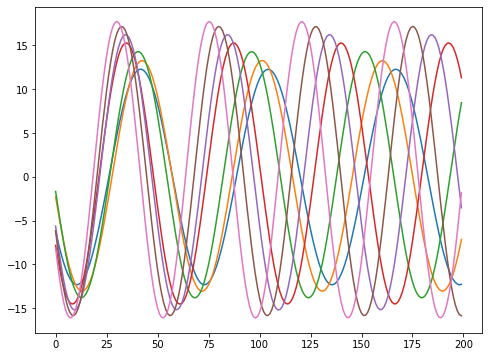

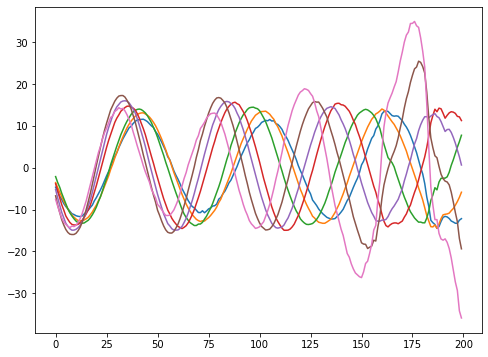

In [11]:
# latent_vectors, gen_x = find_latent(x_train)

# Gaussian
reconstruction_temp, _, _, _ = Decoder(latent_vectors, training=False)
reconstruction = reconstruction_temp * maximum

print(reconstruction.shape)
reconstruction=np.reshape(reconstruction,[reconstruction.shape[0],reconstruction.shape[1]])

plt.figure()
plt.plot(np.transpose(np.reshape(x_train,[x_train.shape[0],x_train.shape[1]]))*maximum)

plt.figure()
plt.plot(np.transpose(reconstruction[:,:]))



In [12]:
x_train = x_train*maximum

In [13]:
num_inter=latent_vectors.shape[0]-1
latent_inter_temp=np.zeros([num_inter,latent_vectors.shape[1]])
for i in range(num_inter):
    latent_inter_temp[i,:]=latent_vectors[i,:]+(latent_vectors[i+1,:]-latent_vectors[i,:])*0.5
    
latent_inter=latent_inter_temp
latent_inter=np.reshape(latent_inter,[latent_inter.shape[0],latent_inter.shape[1]])


In [14]:
# Gaussian
interpolation_temp, _, _, _ = Decoder(latent_inter, training=False)
interpolation=interpolation_temp*maximum

interpolation=np.reshape(interpolation,[interpolation.shape[0],interpolation.shape[1]])

print(interpolation.shape)


(6, 200)


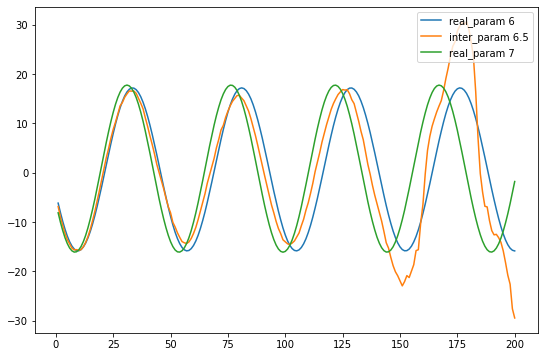

In [15]:
inter=6.5 # 1.5 ~ 6.5  // 3.5 (re=800) 고정
legend11='real_param %d' % int(inter-0.5)
legend12='inter_param %.1f' % (inter)
legend13='real_param %d' % int(inter+0.5)

plt.figure(figsize=(9, 6))
plt.plot(x_axis, x_train[int(inter-1.5),:,:])
plt.plot(x_axis, interpolation[int(inter-1.5),:])
plt.plot(x_axis, x_train[int(inter-0.5),:,:])
# plt.plot(x_axis, x_train[int(inter-1.5),:,:]+(x_train[int(inter-0.5),:,:]-x_train[int(inter-1.5),:,:])*0.5)

plt.legend([legend11,legend12,legend13],loc='upper right')

In [16]:
test_num=6  # 2 ~ 6

latent_inter_mid=latent_vectors[test_num-2,:]+(latent_vectors[test_num,:]-latent_vectors[test_num-2,:])*0.5

print(latent_inter_mid.shape)

latent_inter_mid=np.reshape(latent_inter_mid,[1, latent_vectors.shape[1]])

print(latent_inter_mid.shape)

# Gaussian
interpolation_mid_temp, _, _, _  = Decoder(latent_inter_mid, training=False)
interpolation_mid=interpolation_mid_temp*maximum

(2,)
(1, 2)


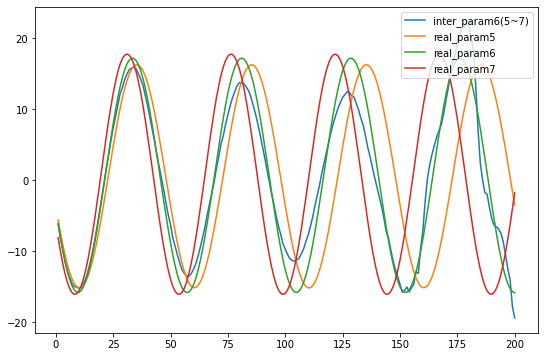

In [17]:
interpolation_mid=np.reshape(interpolation_mid,[interpolation_mid.shape[0],interpolation_mid.shape[1]])

plt.figure(figsize=(9, 6))
plt.plot(x_axis, interpolation_mid[0,:])
plt.plot(x_axis, x_train[test_num-2,:])
plt.plot(x_axis, x_train[test_num-1,:])
plt.plot(x_axis, x_train[test_num,:])
# plt.plot(x_axis, x_train[test_num-2,:,:]+(x_train[test_num,:,:]-x_train[test_num-2,:,:])*0.5)

legend21 = 'inter_param%d(%d~%d)' %(test_num, test_num-1, test_num+1)
legend22 = 'real_param%d' %(test_num-1)
legend23 = 'real_param%d' %(test_num)
legend24 = 'real_param%d' %(test_num+1)

plt.legend([legend21,legend22,legend23,legend24],loc='upper right')


In [18]:
filename3='LVAE_test_shared/mode%d/result_mode%d/reconstruction_%ds-VAE-%d' % (mode, mode,timelength/100, epoch)
filename4='LVAE_test_shared/mode%d/result_mode%d/interpolation_%ds-VAE-%d' % (mode, mode,timelength/100, epoch)
filename5='LVAE_test_shared/mode%d/result_mode%d/interpolation_%ds_%d(%d~%d)-VAE-%d' % (mode, mode,timelength/100, test_num, test_num-1, test_num+1, epoch)

np.savetxt(filename3, reconstruction, fmt='%f')
np.savetxt(filename4, interpolation, fmt='%f')
np.savetxt(filename5, interpolation_mid, fmt='%f')